In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [18]:
df = pd.read_csv('../Top_lane.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [19]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,86,4,3,9,3,1,12374,3836,2547,26232,8472,14,0,12,31,Garen
1,92,9,7,1,4,1,15022,3893,692,22422,11106,15,3,20,26,Riven
2,39,6,10,3,3,2,17448,3386,2879,34884,14624,17,5,19,10,Irelia
3,266,4,8,3,0,1,18326,12718,6744,30262,10812,15,6,26,19,Aatrox
4,31,3,4,2,3,1,13311,1453,745,23144,8896,13,1,13,66,Chogath


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [20]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [21]:
lane = lane.groupby("Champion").mean()

In [22]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
2,6.270471,4.824648,6.133995,3.251447,1.531844,14381.842018,19519.489661,2312.845327,25512.636890,10620.894955,13.299421,3.421009,23.865178,11.836228
6,5.866667,4.431579,4.936842,3.235088,1.501754,14803.828070,7969.870175,3099.638596,20139.428070,10557.989474,13.873684,1.996491,20.147368,19.178947
8,4.811801,4.382503,5.179044,2.514751,1.357070,17359.970498,5700.062055,2689.551373,24090.948118,10212.516785,13.963377,1.886063,16.782299,3.326551
10,4.510526,5.431579,6.242105,2.200000,1.347368,15872.552632,8771.226316,3764.315789,20482.821053,10838.752632,13.936842,1.410526,19.289474,7.357895
14,3.209945,5.232044,7.038674,1.441989,1.044199,12995.834254,4829.248619,2996.232044,27392.790055,9223.419890,13.779006,1.817680,17.546961,34.701657


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

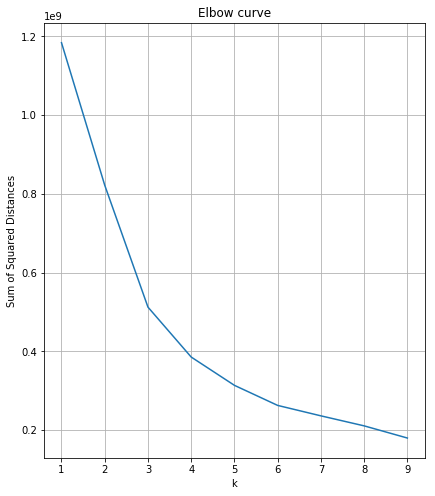

In [25]:
distorsions = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.plot(range(1, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [26]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

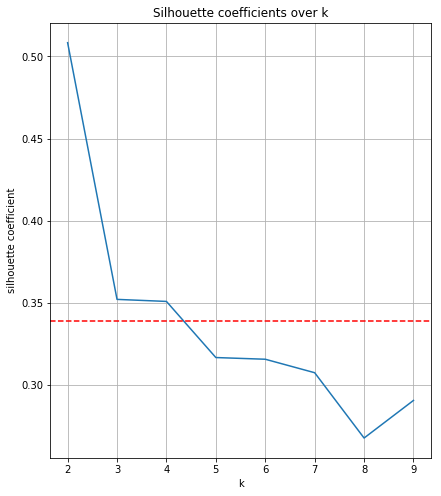

In [27]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

This does not really tell me about how many clusters there should be in the Top Lane. Based on the Elbow plot above, the point of diminishing returns really begins at k = 4.

In [28]:
k_means = KMeans(n_clusters = 4).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [29]:
cluster_assignments

array([3, 2, 1, 2, 1, 2, 3, 2, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0,
       1, 2, 2, 1, 2, 0, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 1, 0], dtype=int32)

In [30]:
clustered = lane.groupby('Champion').mean()

In [31]:
clustered['Cluster'] = cluster_assignments

In [32]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0     6
1    18
2    13
3     3
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [33]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,3.679660,4.872899,7.301629,1.839382,1.109889,12554.923580,4538.809227,2101.494878,19974.794890,9043.314533,13.329417,2.105239,20.552039,26.532470
1,4.622620,4.962392,5.368037,2.338133,1.284488,14863.334874,6616.985418,3319.902062,25034.230140,10002.007978,13.697567,1.707730,17.337458,20.852430
2,4.978041,4.851207,5.533826,2.543045,1.319263,16273.574326,8142.233842,3788.701483,19035.210740,10492.398545,13.849101,1.933306,19.225971,15.637399
3,6.202017,5.080859,5.227834,3.048789,1.457451,14831.864555,17612.171426,3922.774555,25620.848162,11072.864636,13.764979,2.123762,23.054777,9.976502


In [34]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [43]:
clustered[clustered['Cluster'] == 3]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
2,6.270471,4.824648,6.133995,3.251447,1.531844,14381.842018,19519.489661,2312.845327,25512.636890,10620.894955,13.299421,3.421009,23.865178,11.836228,3,Olaf
23,5.027422,4.881170,3.983547,2.458867,1.360146,14622.045704,14601.005484,6722.594150,26662.195612,11518.959781,14.351005,1.360146,17.197441,8.478976,3,Tryndamere
107,7.308157,5.536757,5.565962,3.436052,1.480363,15491.705942,18716.019134,2732.884189,24687.711984,11078.739174,13.644512,1.590131,28.101712,9.614300,3,Rengar


# 

In [33]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,4.662904,4.972937,5.380533,2.358406,1.286442,14836.899486,6665.628455,3359.852975,24848.561812,10009.423950,13.693988,1.728013,17.391723,20.676021
1,4.826588,4.847850,5.487744,2.457752,1.299150,16614.412039,8597.806923,4041.062273,18759.252041,10565.572019,13.872296,1.858563,19.548434,15.028595
2,6.202017,5.080859,5.227834,3.048789,1.457451,14831.864555,17612.171426,3922.774555,25620.848162,11072.864636,13.764979,2.123762,23.054777,9.976502
3,4.142325,4.832729,6.908325,2.099381,1.187080,13297.603103,4945.327869,2171.562051,19775.932082,9357.804579,13.457788,2.135710,19.924628,24.336800
